In [ ]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVC
from sklearn.cluster import KMeans

import datetime

#from library.sb_utils import save_file

In [ ]:
tf_df = pd.read_csv('../data/raw/data/track_features/tf_mini.csv')
tf_df_dummy = pd.get_dummies(tf_df, columns=['key','time_signature','mode'])

In [ ]:
from sklearn.preprocessing import StandardScaler

# only pick these columns to do the clustering
sel_col_names = ['acousticness','beat_strength','danceability',
                        'dyn_range_mean', 'energy', 'flatness','instrumentalness', 'liveness', 
                        'loudness', 'mechanism', 'organism','speechiness','valence',
                        'acoustic_vector_0','acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3',
                        'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6','acoustic_vector_7']
x_cols = tf_df_dummy[sel_col_names]

# rescale the data
scaler = StandardScaler()
x_cols_scaled = scaler.fit_transform(x_cols)

In [ ]:
# k = 50 looks ok
km_model = KMeans(n_clusters = 100, random_state=23)
km_model.fit(x_cols_scaled)
clus = pd.DataFrame(km_model.predict(x_cols_scaled))
clus_count = pd.DataFrame(clus.value_counts(), columns = ['count']).reset_index()
clus_count
ax = sns.barplot(x = clus_count.iloc[:,0], y = clus_count['count'])
ax.set(xlabel='K', ylabel='count')
plt.tight_layout()
plt.show()

In [ ]:
tf_df_dummy['clus'] = clus
tf_df_dummy['clus'] = 'c' + tf_df_dummy['clus'].astype(str)

In [ ]:
log_df = pd.read_csv('../data/raw/data/training_set/log_mini.csv')
log_df_dummy = pd.get_dummies(log_df, columns=['hist_user_behavior_reason_end', 'hist_user_behavior_reason_start', 'context_type'])


In [ ]:
df = log_df_dummy.merge(tf_df_dummy, left_on = 'track_id_clean', right_on = 'track_id')
df.sort_values(by = ['session_id', 'session_position'],inplace = True)
df

In [ ]:
df.columns

In [ ]:
df.dtypes[0:30]

In [ ]:
bool_col = ['skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_is_shuffle','premium',
       'hist_user_behavior_reason_end_backbtn',
       'hist_user_behavior_reason_end_clickrow',
       'hist_user_behavior_reason_end_endplay',
       'hist_user_behavior_reason_end_fwdbtn',
       'hist_user_behavior_reason_end_logout',
       'hist_user_behavior_reason_end_remote',
       'hist_user_behavior_reason_end_trackdone',
       'hist_user_behavior_reason_start_appload',
       'hist_user_behavior_reason_start_backbtn',
       'hist_user_behavior_reason_start_clickrow',
       'hist_user_behavior_reason_start_endplay',
       'hist_user_behavior_reason_start_fwdbtn',
       'hist_user_behavior_reason_start_playbtn',
       'hist_user_behavior_reason_start_remote',
       'hist_user_behavior_reason_start_trackdone',
       'hist_user_behavior_reason_start_trackerror', 'context_type_catalog',
       'context_type_charts', 'context_type_editorial_playlist',
       'context_type_personalized_playlist', 'context_type_radio',
       'context_type_user_collection', 
       'key_0', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'time_signature_0', 'time_signature_1', 'time_signature_3',
       'time_signature_4', 'time_signature_5', 'mode_major', 'mode_minor']

df[bool_col] = df[bool_col].astype('bool')

In [ ]:
# does not help
# df.loc[:,df.dtypes=='int64'] = df.loc[:,df.dtypes=='int64'].astype('float')

In [ ]:
df.dtypes[0:30]

## Data spliting
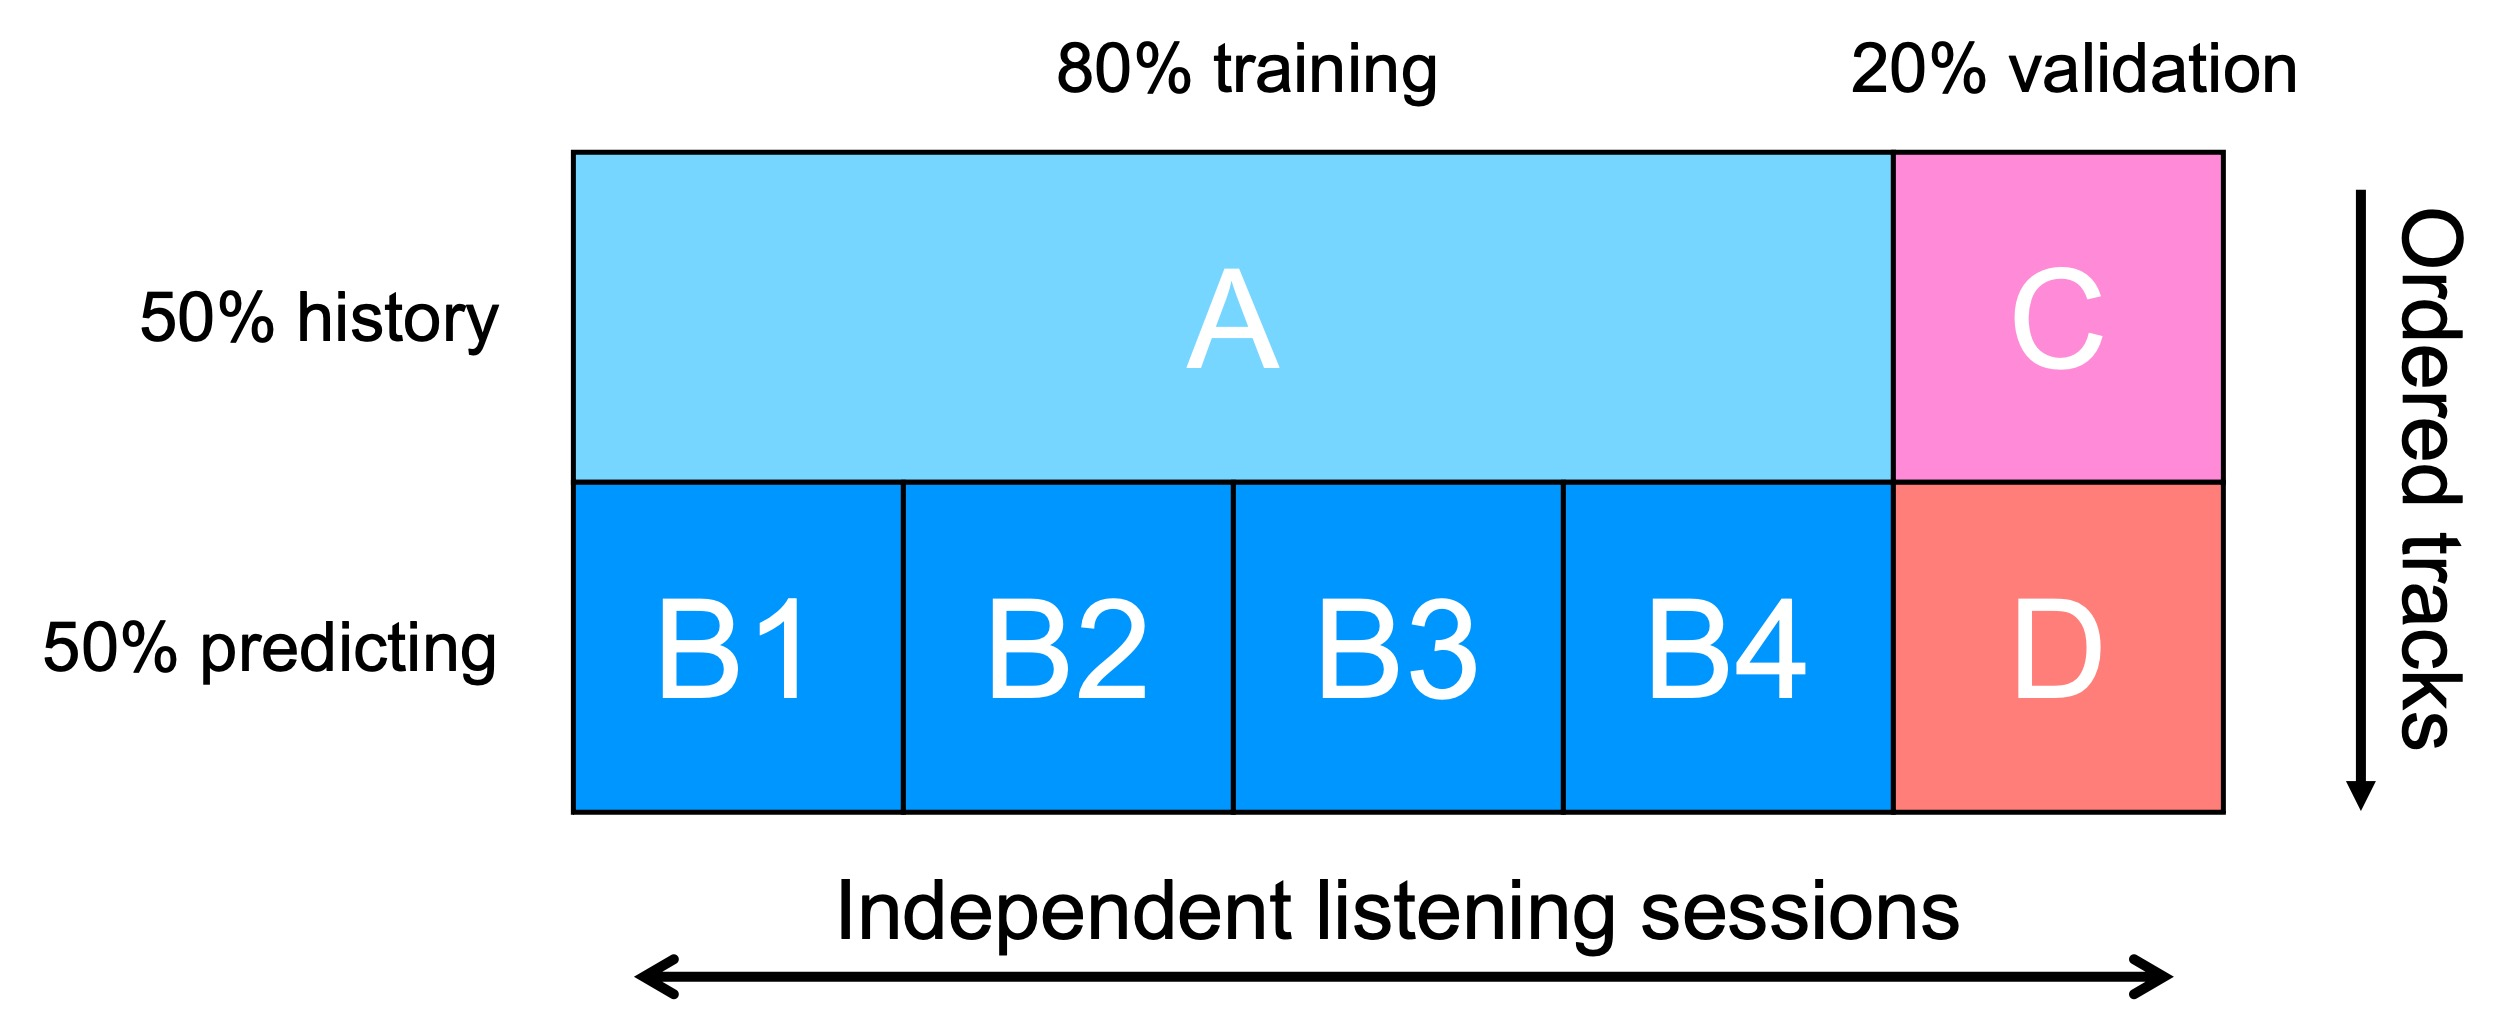


In [ ]:
# splitting the data

from sklearn.model_selection import StratifiedKFold, GroupKFold

# splitting the validation and training sessions
train_list = []
test_list = []
gkf = GroupKFold(n_splits=5)
for train, test in gkf.split(df, groups = df['session_id']):
    train_list.append(train)
    test_list.append(test)
    
df_train = df.iloc[train_list[0].tolist()] # training set (A+B)
df_valid = df.iloc[test_list[0].tolist()] # validation set (C+D), untouched



# split the data into history (A) and predicting (B)
skf1 = StratifiedKFold(n_splits=2)
history_list = []
predicting_list = []
for h, p in skf1.split(df_train, df_train['session_id']):
    history_list.append(h)
    predicting_list.append(p)
        
df_history = df_train.iloc[history_list[1].tolist()]
df_predicting = df_train.iloc[predicting_list[1].tolist()]



# split the valid data into history (C) and predicting (D)
skf2 = StratifiedKFold(n_splits=2)
history_list = []
predicting_list = []
for h, p in skf2.split(df_valid, df_valid['session_id']):
    history_list.append(h)
    predicting_list.append(p)
        
df_valid_history = df_valid.iloc[history_list[1].tolist()]
df_valid_predicting = df_valid.iloc[predicting_list[1].tolist()]




# split the predicting set (B) into 4 cross-validation groups
# no need to split history set (A), as it will be used to calculate the similarity matrix
train_pred_list = []
test_pred_list = []
gkf2 = GroupKFold(n_splits=4)
for train, test in gkf2.split(df_predicting, groups = df_predicting['session_id']):
    train_pred_list.append(train)
    test_pred_list.append(test)
    
df_train_pred_set1 = df_predicting.iloc[train_pred_list[0].tolist()] # training_predicting set (B2 + B3 + B4)
df_train_pred_set2 = df_predicting.iloc[train_pred_list[1].tolist()] # training_predicting set (B1 + B3 + B4)
df_train_pred_set3 = df_predicting.iloc[train_pred_list[2].tolist()] # training_predicting set (B1 + B2 + B4)
df_train_pred_set4 = df_predicting.iloc[train_pred_list[3].tolist()] # training_predicting set (B1 + B2 + B3)


df_test_pred_set1 = df_predicting.iloc[test_pred_list[0].tolist()] # testing_predicting set (B1)
df_test_pred_set2 = df_predicting.iloc[test_pred_list[1].tolist()] # testing_predicting set (B2)
df_test_pred_set3 = df_predicting.iloc[test_pred_list[2].tolist()] # testing_predicting set (B3)
df_test_pred_set4 = df_predicting.iloc[test_pred_list[3].tolist()] # testing_predicting set (B4)

df_history_valid = pd.concat([df_train, df_valid_history])

In [ ]:
def cal_similarMat(df_train):
    import numpy as np
    import pandas as pd
    
    sessions = list(np.sort(df_train['session_id'].unique())) 
    tracks = list(df_train['clus'].unique()) 
    no_skip_2 = (list(df_train['skip_2']==False))*1 # use *1 to convert bool to integer
    
    DfSessionUnique = []
    DfSessionUnique = pd.DataFrame(sessions,columns=['sessions'])
    
    from scipy import sparse
    from pandas.api.types import CategoricalDtype

    rows = df_train['session_id'].astype(CategoricalDtype(categories=sessions)).cat.codes # unique sessions (index)

    # Get the associated row indices
    cols = df_train['clus'].astype(CategoricalDtype(categories=tracks)).cat.codes # unique tracks (column)
    
    
    # Get the associated column indices
    #Compressed Sparse Row matrix
    listeningSparse = []
    listeningSparse = sparse.csr_matrix((no_skip_2, (rows, cols)), shape=(len(sessions), len(tracks)))
    #csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
    #where data, row_ind and col_ind satisfy the relationship a[row_ind[k], col_ind[k]] = data[k]. , see https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

    listeningSparse
    #a sparse matrix is not a pandas dataframe, but sparse matrices are efficient for row slicing and fast matrix vector products
    
    
    DataBinary = df_train.copy()
    DataBinary['ListenYes'] = (DataBinary['skip_2'] == False)*1
    
    data2=DataBinary[['session_id','clus','ListenYes']]

    data2['ListenYes'].replace(0, -1, inplace = True)

    data3 = data2.groupby(['session_id', 'clus']).agg({'ListenYes':['sum']})
    data3 = data3.reset_index()
    data3.columns = data3.columns.droplevel(level = 1) # take out the unwanted level
    
    
    DfMatrix = pd.pivot_table(data3, values='ListenYes', index='session_id', columns='clus')

    DfMatrix=DfMatrix.fillna(0) #NaN values need to get replaced by 0, meaning they have not been listened yet.
    
    DfResetted = DfMatrix.reset_index().rename_axis(None, axis=1) 

    DfTracksListen = DfResetted.drop(columns=['session_id'])

    #Normalization
    import numpy as np
    DfTracksListenNorm = DfTracksListen / np.sqrt(np.square(DfTracksListen).sum(axis=0)) 

    #### similarity and correlation
    # Calculating with Vectors to compute Cosine Similarities
    TrackTrackSim = DfTracksListenNorm.transpose().dot(DfTracksListenNorm) 

    #Another approach to the above would be using correlation
    TrackTrackCorr = DfTracksListenNorm.corr()
    
    #Spearman correlation
    TrackTrackSpearCorr = DfTracksListenNorm.corr(method = 'spearman')
    
    #Kendall correlation
    TrackTrackKendCorr = DfTracksListenNorm.corr(method = 'kendall')
    
    from scipy.spatial.distance import cdist
    
    #### distances
    # Euclidean distance
    TrackTrackEuclDist = pd.DataFrame(cdist(DfTracksListenNorm.T,DfTracksListenNorm.T, 'euclidean'), index = TrackTrackSim.index, columns = TrackTrackSim.columns)

    # Squared Euclidean distance
    TrackTrackSqEuclDist = pd.DataFrame(cdist(DfTracksListenNorm.T,DfTracksListenNorm.T, 'sqeuclidean'), index = TrackTrackSim.index, columns = TrackTrackSim.columns)
    
    # Manhattan distance
    TrackTrackManhDist = pd.DataFrame(cdist(DfTracksListenNorm.T,DfTracksListenNorm.T, 'cityblock'), index = TrackTrackSim.index, columns = TrackTrackSim.columns)

    # Canberra distance
    TrackTrackCanbDist = pd.DataFrame(cdist(DfTracksListenNorm.T,DfTracksListenNorm.T, 'canberra'), index = TrackTrackSim.index, columns = TrackTrackSim.columns)

    #### boolean distances
    # Hamming distance
    TrackTrackHammDist = pd.DataFrame(cdist(DfTracksListenNorm.T>0,DfTracksListenNorm.T>0, 'hamming'), index = TrackTrackSim.index, columns = TrackTrackSim.columns)

 

    # Create a place holder matrix for similarities, and fill in the session column
    SessTrackSimilarity = pd.DataFrame(index=DfResetted.index, columns=DfResetted.columns)
    SessTrackSimilarity.iloc[:,:1] = DfResetted.iloc[:,:1]
    SessTrackCorrelation = SessTrackSimilarity.copy()
    SessTrackSpearCorr = SessTrackSimilarity.copy()
    SessTrackKendCorr = SessTrackSimilarity.copy()
    SessTrackEuclDist = SessTrackSimilarity.copy()
    SessTrackSqEuclDist = SessTrackSimilarity.copy()
    SessTrackManhDist = SessTrackSimilarity.copy()
    SessTrackCanbDist = SessTrackSimilarity.copy()
    SessTrackHammDist = SessTrackSimilarity.copy()

    #We now loop through the rows and columns filling in empty spaces with similarity scores.
    
    SessionListening = []
    TrackTopSimilarity = []

    for i in range(0,len(SessTrackSimilarity.index)):
        for j in range(1,len(SessTrackSimilarity.columns)):

            ses = SessTrackSimilarity.index[i]
            tra = SessTrackSimilarity.columns[j]

            SessionListening = DfTracksListen.loc[ses,]
            TrackSimilarity = TrackTrackSim[tra]
            TrackCorrelation = TrackTrackCorr[tra]
            TrackSpearCorr = TrackTrackSpearCorr[tra]
            TrackKendCorr = TrackTrackKendCorr[tra]
            TrackEuclDist = TrackTrackEuclDist[tra]
            TrackSqEuclDist = TrackTrackSqEuclDist[tra]
            TrackManhDist = TrackTrackManhDist[tra]
            TrackCanbDist = TrackTrackCanbDist[tra]
            TrackHammDist = TrackTrackHammDist[tra]

            SessTrackSimilarity.loc[i][j] = sum(SessionListening*TrackSimilarity)/sum(TrackSimilarity)
            SessTrackCorrelation.loc[i][j] = sum(SessionListening*TrackCorrelation)/sum(TrackCorrelation)
            SessTrackSpearCorr.loc[i][j] = sum(SessionListening*TrackSpearCorr)/sum(TrackSpearCorr)
            SessTrackKendCorr.loc[i][j] = sum(SessionListening*TrackKendCorr)/sum(TrackKendCorr)
            SessTrackEuclDist.loc[i][j] = sum(SessionListening*TrackEuclDist)/sum(TrackEuclDist)
            SessTrackSqEuclDist.loc[i][j] = sum(SessionListening*TrackSqEuclDist)/sum(TrackSqEuclDist)
            SessTrackManhDist.loc[i][j] = sum(SessionListening*TrackManhDist)/sum(TrackManhDist)
            SessTrackCanbDist.loc[i][j] = sum(SessionListening*TrackCanbDist)/sum(TrackCanbDist)
            SessTrackHammDist.loc[i][j] = sum(SessionListening*TrackHammDist)/sum(TrackHammDist)

    
    SessTrackSimilarity.set_index('session_id', inplace = True)
    SessTrackCorrelation.set_index('session_id', inplace = True)
    SessTrackSpearCorr.set_index('session_id', inplace = True)
    SessTrackKendCorr.set_index('session_id', inplace = True)
    SessTrackEuclDist.set_index('session_id', inplace = True)
    SessTrackSqEuclDist.set_index('session_id', inplace = True)
    SessTrackManhDist.set_index('session_id', inplace = True)
    SessTrackCanbDist.set_index('session_id', inplace = True)
    SessTrackHammDist.set_index('session_id', inplace = True)
    
    
    sim_output = [SessTrackSimilarity, SessTrackCorrelation, SessTrackSpearCorr, SessTrackKendCorr, SessTrackEuclDist, SessTrackSqEuclDist, SessTrackManhDist, SessTrackCanbDist, SessTrackHammDist]
    print('Done!')
    
    return sim_output


In [ ]:
# calculate similarity matrix (THIS IS SLOW!!)

import warnings
warnings.simplefilter("ignore")

from timeit import default_timer as timer #to see how long the computation will take
start = timer()

sim_output_set1 = cal_similarMat(pd.concat([df_history,df_train_pred_set1]))
sim_output_set2 = cal_similarMat(pd.concat([df_history,df_train_pred_set2]))
sim_output_set3 = cal_similarMat(pd.concat([df_history,df_train_pred_set3]))
sim_output_set4 = cal_similarMat(pd.concat([df_history,df_train_pred_set4]))
sim_output_valid = cal_similarMat(df_history_valid)


end = timer()
print('\nRuntime: %0.2fs' % (end - start))

In [ ]:
def SimLookup(sim_output, df_test_pred):
    df_test_pred['cos_score']=sim_output[0].lookup(df_test_pred['session_id'],df_test_pred['clus'])
    df_test_pred['corr_score']=sim_output[1].lookup(df_test_pred['session_id'],df_test_pred['clus'])
    df_test_pred['SpearCorr_score']=sim_output[2].lookup(df_test_pred['session_id'],df_test_pred['clus'])
    df_test_pred['KendCorr_score']=sim_output[3].lookup(df_test_pred['session_id'],df_test_pred['clus'])
    df_test_pred['EuclDist']=sim_output[4].lookup(df_test_pred['session_id'],df_test_pred['clus'])
    df_test_pred['SqEuclDist']=sim_output[5].lookup(df_test_pred['session_id'],df_test_pred['clus'])
    df_test_pred['ManhDist']=sim_output[6].lookup(df_test_pred['session_id'],df_test_pred['clus'])
    df_test_pred['CanbDist']=sim_output[7].lookup(df_test_pred['session_id'],df_test_pred['clus'])
    if len(sim_output) == 9:
        df_test_pred['HammDist']=sim_output[8].lookup(df_test_pred['session_id'],df_test_pred['clus'])
        
    return df_test_pred
    


In [ ]:
import warnings
warnings.simplefilter("ignore")

df_test_pred_set1 = SimLookup(sim_output_set1, df_test_pred_set1)
df_test_pred_set2 = SimLookup(sim_output_set2, df_test_pred_set2)
df_test_pred_set3 = SimLookup(sim_output_set3, df_test_pred_set3)
df_test_pred_set4 = SimLookup(sim_output_set4, df_test_pred_set4)



In [ ]:
def featureAugment(df_history, cols):
    df_fa = pd.DataFrame()
        
    for c in cols:
        df_fa[c+'_mean'] = df_history.groupby(['session_id'])[c].mean()
        df_fa[c+'_std'] = df_history.groupby(['session_id'])[c].std()
        df_fa[c+'_skew'] = df_history.groupby(['session_id'])[c].skew()
        df_fa[c+'_median'] = df_history.groupby(['session_id'])[c].median()
        if df_history[c].dtypes.name != 'bool':
            df_fa[c+'_max'] = df_history.groupby(['session_id'])[c].max()
            df_fa[c+'_min'] = df_history.groupby(['session_id'])[c].min()
            df_fa[c+'_range'] = np.subtract(df_fa[c+'_max'], df_fa[c+'_min'], dtype=np.float32)
            df_fa[c+'_q25'] = df_history.groupby(['session_id'])[c].quantile(.25)
            df_fa[c+'_q75'] = df_history.groupby(['session_id'])[c].quantile(.75)
            df_fa[c+'_iqr'] = np.subtract(df_fa[c+'_q75'], df_fa[c+'_q25'], dtype=np.float32)
#             df_fa[c+'_mode'] = df_history.groupby(['session_id'])[c].agg(pd.Series.mode)
#             df_fa[c+'_PearsonTrend'] = df_history.groupby(['session_id'])[c, 'session_position'].corr().iloc[0::2,-1]
#             df_fa[c+'_SpearTrend'] = df_history.groupby(['session_id'])[c, 'session_position'].corr('spearman').iloc[0::2,-1]
#             df_fa[c+'_KendallTrend'] = df_history.groupby(['session_id'])[c, 'session_position'].corr('kendall').iloc[0::2,-1]

    print('Done!')
    return df_fa

In [ ]:
import warnings
warnings.simplefilter("ignore")

col_FA = ['session_position', 'session_length', 
       'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'premium',
       'hist_user_behavior_reason_end_backbtn',
       'hist_user_behavior_reason_end_clickrow',
       'hist_user_behavior_reason_end_endplay',
       'hist_user_behavior_reason_end_fwdbtn',
       'hist_user_behavior_reason_end_logout',
       'hist_user_behavior_reason_end_remote',
       'hist_user_behavior_reason_end_trackdone',
       'hist_user_behavior_reason_start_appload',
       'hist_user_behavior_reason_start_backbtn',
       'hist_user_behavior_reason_start_clickrow',
       'hist_user_behavior_reason_start_endplay',
       'hist_user_behavior_reason_start_fwdbtn',
       'hist_user_behavior_reason_start_playbtn',
       'hist_user_behavior_reason_start_remote',
       'hist_user_behavior_reason_start_trackdone',
       'hist_user_behavior_reason_start_trackerror', 'context_type_catalog',
       'context_type_charts', 'context_type_editorial_playlist',
       'context_type_personalized_playlist', 'context_type_radio',
       'context_type_user_collection', 'duration', 'release_year',
       'us_popularity_estimate', 'acousticness', 'beat_strength', 'bounciness',
       'danceability', 'dyn_range_mean', 'energy', 'flatness',
       'instrumentalness', 'liveness', 'loudness', 'mechanism', 'organism',
       'speechiness', 'tempo', 'valence', 'acoustic_vector_0',
       'acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3',
       'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6',
       'acoustic_vector_7', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'time_signature_0', 'time_signature_1', 'time_signature_3',
       'time_signature_4', 'time_signature_5', 'mode_major', 'mode_minor']

df_fa = featureAugment(df_history, col_FA)

df_test_pred_set1_FA = df_test_pred_set1.merge(df_fa, left_on = 'session_id', right_on = 'session_id')
df_test_pred_set2_FA = df_test_pred_set2.merge(df_fa, left_on = 'session_id', right_on = 'session_id')
df_test_pred_set3_FA = df_test_pred_set3.merge(df_fa, left_on = 'session_id', right_on = 'session_id')
df_test_pred_set4_FA = df_test_pred_set4.merge(df_fa, left_on = 'session_id', right_on = 'session_id')


In [ ]:
len(col_FA)

In [ ]:
drop_cols = ['session_id','skip_1', 'skip_2', 'skip_3', 'not_skipped', 'track_id_clean','context_switch','date',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hist_user_behavior_reason_end_backbtn',
       'hist_user_behavior_reason_end_clickrow',
       'hist_user_behavior_reason_end_endplay',
       'hist_user_behavior_reason_end_fwdbtn',
       'hist_user_behavior_reason_end_logout',
       'hist_user_behavior_reason_end_remote',
       'hist_user_behavior_reason_end_trackdone',
       'hist_user_behavior_reason_start_appload',
       'hist_user_behavior_reason_start_backbtn',
       'hist_user_behavior_reason_start_clickrow',
       'hist_user_behavior_reason_start_endplay',
       'hist_user_behavior_reason_start_fwdbtn',
       'hist_user_behavior_reason_start_playbtn',
       'hist_user_behavior_reason_start_remote',
       'hist_user_behavior_reason_start_trackdone',
       'hist_user_behavior_reason_start_trackerror', 'context_type_catalog',
       'context_type_charts', 'context_type_editorial_playlist',
       'context_type_personalized_playlist', 'context_type_radio',
       'context_type_user_collection','track_id','clus']

In [ ]:
df_test_pred_set1_FA.drop(columns = drop_cols).columns[0:100]

In [ ]:
df_test_pred_set1_FA.loc[:,df_test_pred_set1_FA.isna().mean()==1].columns

In [ ]:
## evaludation functions

def get_ground_truth(test_output):

    ground_truths = [] 
    df = test_output.copy()
    df[['session_position','session_length']] = df[['session_position','session_length']].astype('int64')
    df = df[['session_id','skip_2','session_position','session_length']].loc[df['session_position']*2 > df['session_length']]
    df = df.reset_index()
    current_index = 0
    while current_index < len(df):
        partial_length = df['session_length'].iloc[current_index]-df['session_position'].iloc[current_index]+1
        session_skips = list(df.loc[current_index:current_index+partial_length-1, 'skip_2'])
        ground_truths.append(session_skips)
        current_index += partial_length 
        
    return ground_truths


def get_submission(test_output):
    submission = []
    for s in test_output['session_id'].unique():
        submission.append(np.array(test_output['pred'][test_output['session_id']==s]*1))
        
    return submission


def evaluate(submission,groundtruth):
    ap_sum = 0.0
    first_pred_acc_sum = 0.0
    counter = 0
    for sub, tru in zip(submission, groundtruth):
        if len(sub) != len(tru):
            raise Exception('Line {} should contain {} predictions, but instead contains '
                            '{}'.format(counter+1,len(tru),len(sub)))
        ap_sum += ave_pre(sub,tru,counter)
        first_pred_acc_sum += sub[0] == tru[0]
        counter+=1
    ap = ap_sum/counter
    first_pred_acc = first_pred_acc_sum/counter
    return ap,first_pred_acc


def ave_pre(submission,groundtruth,counter):
    s = 0.0
    t = 0.0
    c = 1.0
    for x, y in zip(submission, groundtruth):
        if x != 0 and x != 1:
            raise Exception('Invalid prediction in line {}, should be 0 or 1'.format(counter))
        if x==y:
            s += 1.0
            t += s / c
        c += 1
    return t/len(groundtruth)

In [ ]:
def run_RF(test_set, train_set, drop_cols):

    X_train = pd.concat(train_set).drop(columns = drop_cols)
    X_test = test_set.drop(columns = drop_cols)
    y_train = pd.concat(train_set)['skip_2']
    y_test = test_set['skip_2']
    
    test_output = test_set.copy()


    rf = RandomForestClassifier(random_state=23, n_jobs = -1, max_depth=10, n_estimators = 300)
    rf.fit(X_train,y_train)
    score_train = rf.score(X_train,y_train)
    score_test = rf.score(X_test,y_test)
    test_output['pred'] = rf.predict(X_test)
    print('score_train',score_train)
    print('score_test',score_test)


    
    # official evaluation  metrices
    ground_truths = get_ground_truth(test_output)
    submission = get_submission(test_output)
    
    ap,first_pred_acc = evaluate(submission,ground_truths)
    
    print('average precision: {}'.format(ap))
    print('first prediction accuracy: {}'.format(first_pred_acc))
    
    
    
    
    importances = pd.DataFrame({'FEATURE':X_train.columns,'IMPORTANCE':np.round(rf.feature_importances_,3)})
    importances = importances.sort_values('IMPORTANCE',ascending=False).set_index('FEATURE')

    fig, ax = plt.subplots(figsize=(10,5)) 
    sel_range = 30
    sns.barplot(y = importances[0:sel_range].index, x = importances['IMPORTANCE'][0:sel_range], orient = 'h', ax = ax)

    plt.tight_layout()
    plt.show()

In [ ]:
run_RF(df_test_pred_set1_FA, [df_test_pred_set2_FA,df_test_pred_set3_FA,df_test_pred_set4_FA], drop_cols)

In [ ]:
run_RF(df_test_pred_set2_FA, [df_test_pred_set1_FA,df_test_pred_set3_FA,df_test_pred_set4_FA], drop_cols)

In [ ]:
run_RF(df_test_pred_set3_FA, [df_test_pred_set2_FA,df_test_pred_set1_FA,df_test_pred_set4_FA], drop_cols)

In [ ]:
run_RF(df_test_pred_set4_FA, [df_test_pred_set2_FA,df_test_pred_set3_FA,df_test_pred_set1_FA], drop_cols)

In [35]:
def run_SVC(test_set, train_set, drop_cols):

    X_train = pd.concat(train_set).drop(columns = drop_cols)
    X_test = test_set.drop(columns = drop_cols)
    y_train = pd.concat(train_set)['skip_2']
    y_test = test_set['skip_2']
    
    clf = make_pipeline(StandardScaler(), SVC())
    clf.fit(X_train,y_train)
    score_train = clf.score(X_train,y_train)
    score_test = clf.score(X_test,y_test)
    
    print('score_train',score_train)
    print('score_test',score_test)


In [36]:
run_SVC(df_test_pred_set1_FA, [df_test_pred_set2_FA,df_test_pred_set3_FA,df_test_pred_set4_FA], drop_cols)

score_train 0.7633230084981336
score_test 0.6350369311412914


In [37]:
run_SVC(df_test_pred_set2_FA, [df_test_pred_set1_FA,df_test_pred_set3_FA,df_test_pred_set4_FA], drop_cols)

score_train 0.7664998808672862
score_test 0.6237193233261854


In [38]:
run_SVC(df_test_pred_set3_FA, [df_test_pred_set2_FA,df_test_pred_set1_FA,df_test_pred_set4_FA], drop_cols)

score_train 0.7678301961718688
score_test 0.6252680486061473


In [39]:
run_SVC(df_test_pred_set4_FA, [df_test_pred_set2_FA,df_test_pred_set3_FA,df_test_pred_set1_FA], drop_cols)

score_train 0.7674330871257248
score_test 0.6196688110555159


In [ ]:
# df_test_set4_FA.drop(columns = ['session_id', 'session_position', 'track_id_clean', 'skip_1',
#        'skip_3', 'not_skipped', 'context_switch', 'no_pause_before_play','date', 'hour_of_day', 'premium'
#        'short_pause_before_play', 'long_pause_before_play',
#        'hist_user_behavior_is_shuffle', 
#        'hist_user_behavior_reason_start_appload',
#        'hist_user_behavior_reason_start_backbtn',
#        'hist_user_behavior_reason_start_clickrow',
#        'hist_user_behavior_reason_start_endplay',
#        'hist_user_behavior_reason_start_fwdbtn',
#        'hist_user_behavior_reason_start_playbtn',
#        'hist_user_behavior_reason_start_remote',
#        'hist_user_behavior_reason_start_trackdone',
#        'hist_user_behavior_reason_start_trackerror', 'context_type_catalog',
#        'context_type_charts', 'context_type_editorial_playlist',
#        'context_type_personalized_playlist', 'context_type_radio',
#        'context_type_user_collection', 'track_id','clus'], inplace = True)

# df_test_set4_FA.columns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_test_set4_FA.drop(columns = 'skip_2'), df_test_set4_FA['skip_2'], test_size=0.2, random_state=23)

In [ ]:
rf1 = RandomForestClassifier(random_state=23, n_jobs = -1)
rf1.fit(X_train, y_train)
score_train = rf1.score(X_train,y_train)
score_test = rf1.score(X_test,y_test)
print('score_train',score_train)
print('score_test',score_test)

In [ ]:
importances = pd.DataFrame({'FEATURE':X_train.columns,'IMPORTANCE':np.round(RF_MulClass.feature_importances_,3)})
importances = importances.sort_values('IMPORTANCE',ascending=False).set_index('FEATURE')

fig, ax = plt.subplots(figsize=(10,5)) 
sel_range = 30
sns.barplot(y = importances[0:sel_range].index, x = importances['IMPORTANCE'][0:sel_range], orient = 'h', ax = ax)

plt.tight_layout()
plt.show()

In [2]:
# load the feature matrix to check whether it was properly saved.

feature_matrix = pd.read_csv('../data/processed/recomFilter_20221121.csv')
feature_matrix.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
session_id,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e
session_position,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
session_length,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
track_id_clean,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,t_c815228b-3212-4f9e-9d4f-9cb19b248184,t_e23c19f5-4c32-4557-aa44-81372c2e3705,t_0be6eced-f56f-48bd-8086-f2e0b760fdee,t_f3ecbd3b-9e8e-4557-b8e0-39cfcd7e65dd,t_2af4dfa0-7df3-4b7e-b7ab-353ba48237f9,t_79570b2a-639a-4ec0-9853-71c5299ac44d,t_69016f19-84aa-40c0-afa9-54404397b7a2,t_59dc3fcd-7aec-4da5-a747-b59b19bab3bb,t_a157ba98-7eae-4e7d-99d5-ed760b2c0978,t_87d95b75-af5c-4ef6-8dc4-cd888ae17cce,t_db945033-3dc5-4a22-8889-c72fd2781299,t_bff5b6c6-6968-41be-b723-7e860b372975,t_bf496d77-9eb2-4fe1-80f7-2c7ecd6f9b8e,t_1051bc37-1a73-4301-812b-f83ae0c9bbcd,t_358c9cce-7a1e-4dd4-81de-206dda80363f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c5,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391,0.004391
c6,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515
c7,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024,0.00024
c8,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074,-0.109074


In [3]:
feature_matrix.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('bool'), dtype('float64')],
      dtype=object)

In [4]:
feature_matrix.columns[feature_matrix.dtypes=='O']

Index(['session_id', 'track_id_clean', 'date', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end',
       'track_id'],
      dtype='object')

In [5]:
# remove the rows containing NaN, as they are the first few skipped tracks in a session
feature_matrix.drop(columns=['skip_1', 'skip_3','not_skipped',
       'track_id_clean', 'date', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end','track_id',
       'Unnamed: 0'],inplace=True)
#feature_matrix.dropna(inplace=True)

In [6]:
# the function of integrating the skipping labels into one column
def skip_label(df):
    skip = (df['not_skipped']==False).astype(int)*4 # no skip: 0, ultra-late skip: 4
    # It has to go under this order. If skip_1 = True, then skip_2 and _3 will be True too.
    skip[df['skip_3']==True] = 3 # late skip
    skip[df['skip_2']==True] = 2 # mid skip
    skip[df['skip_1']==True] = 1 # early skip
    return skip

# feature_matrix['skip_label'] = skip_label(feature_matrix)

In [7]:
feature_matrix.shape

(167880, 109)

In [8]:
feature_matrix.columns[0:50]

Index(['session_id', 'session_position', 'session_length', 'skip_2',
       'context_switch', 'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'premium', 'duration', 'release_year',
       'us_popularity_estimate', 'acousticness', 'beat_strength', 'bounciness',
       'danceability', 'dyn_range_mean', 'energy', 'flatness',
       'instrumentalness', 'liveness', 'loudness', 'mechanism', 'organism',
       'speechiness', 'tempo', 'valence', 'acoustic_vector_0',
       'acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3',
       'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6',
       'acoustic_vector_7', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10'],
      dtype='object')

In [9]:
feature_matrix.columns[50:]

Index(['key_11', 'time_signature_0', 'time_signature_1', 'time_signature_3',
       'time_signature_4', 'time_signature_5', 'mode_major', 'mode_minor',
       'clus', 'c0', 'c1', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16',
       'c17', 'c18', 'c19', 'c2', 'c20', 'c21', 'c22', 'c23', 'c24', 'c25',
       'c26', 'c27', 'c28', 'c29', 'c3', 'c30', 'c31', 'c32', 'c33', 'c34',
       'c35', 'c36', 'c37', 'c38', 'c39', 'c4', 'c40', 'c41', 'c42', 'c43',
       'c44', 'c45', 'c46', 'c47', 'c48', 'c49', 'c5', 'c6', 'c7', 'c8', 'c9'],
      dtype='object')

In [16]:
feature_matrix[['duration', 'release_year',
       'us_popularity_estimate', 'acousticness', 'beat_strength', 'bounciness',
       'danceability', 'dyn_range_mean', 'energy', 'flatness',
       'instrumentalness', 'liveness', 'loudness', 'mechanism', 'organism',
       'speechiness', 'tempo', 'valence', 'acoustic_vector_0',
       'acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3',
       'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6',
       'acoustic_vector_7']]

,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,...,tempo,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,180.066666,2018,99.968133,0.015848,0.438551,0.473455,0.653119,7.660024,0.553465,1.035007,...,134.024994,0.152255,-0.815775,0.386409,0.230160,0.028028,-0.333373,0.015452,-0.353590,0.205826
1,236.796371,2018,99.896728,0.061811,0.654804,0.735661,0.877393,11.308750,0.726828,1.025636,...,130.037994,0.337152,-0.713646,0.363718,0.310315,-0.042222,-0.383164,0.066357,-0.365308,0.157920
2,231.266663,2018,99.999976,0.354116,0.532155,0.540411,0.679719,8.065802,0.563009,1.029465,...,145.028000,0.373862,-0.742541,0.375599,0.252660,-0.049007,-0.299745,0.063341,-0.486689,0.181604
3,169.826675,2018,99.995038,0.769225,0.641756,0.729224,0.864881,11.287586,0.529484,0.993520,...,111.982002,0.649420,-0.705116,0.317562,0.289141,-0.038920,-0.393358,0.092719,-0.364418,0.285603
4,210.545258,2018,99.998498,0.006602,0.732428,0.794881,0.857778,12.181586,0.650057,1.000571,...,147.031006,0.652921,-0.868489,0.331280,0.210478,0.084740,-0.333287,-0.025706,-0.510350,0.182315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167875,241.306671,2018,99.926393,0.100227,0.559790,0.571664,0.565336,8.411594,0.875369,0.981698,...,155.546005,0.891322,-0.530003,-0.020507,0.221878,0.232069,0.218059,0.086237,-0.181878,0.145040
167876,212.533325,2018,99.905106,0.247189,0.601121,0.632665,0.703095,9.269985,0.529001,1.025182,...,134.427002,0.701824,-0.472023,-0.011628,0.234998,0.169529,0.321254,0.105851,-0.215453,-0.013233
167877,204.293335,2018,99.915604,0.298400,0.706898,0.730013,0.791413,10.419632,0.951893,0.940008,...,153.979996,0.961417,-0.628608,0.052259,0.219314,0.238612,0.032383,0.072873,-0.129108,0.214087
167878,193.773331,2018,99.882031,0.038110,0.492183,0.499016,0.645011,7.658142,0.871987,0.983273,...,87.466003,0.743112,-0.675257,0.102726,0.123573,0.136240,-0.222776,-0.034961,-0.478699,0.197820


# Split the beginning/end of each sequence, random forest classifier, skip_2

This model will predict all the early and late skipping behavior.

In [10]:
data_train_append = []
data_test_append = []
train_perc = 0.8
s_list = feature_matrix['session_id'].unique()

for s_id in s_list:
    temp = []
    temp = feature_matrix.loc[feature_matrix['session_id']==s_id,:]
    data_train_append.append(temp.iloc[0:round(len(temp)*train_perc),:])
    data_test_append.append(temp.iloc[round(len(temp)*train_perc):,:])

data_train = pd.concat(data_train_append)
data_test = pd.concat(data_test_append)

X_train = data_train.drop(columns=['skip_2', 'session_id'])
X_test = data_test.drop(columns=['skip_2', 'session_id'])
y_train = data_train['skip_2']
y_test = data_test['skip_2']

In [13]:
RF_MulClass = RandomForestClassifier(random_state=23, n_jobs = -1)
# imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
# X_train2 = imp_median.fit_transform(X_train)
# X_test2 = imp_median.fit_transform(X_test)

RF_MulClass.fit(X_train, y_train)
score_MulClass_train = RF_MulClass.score(X_train,y_train)
score_MulClass_test = RF_MulClass.score(X_test,y_test)
print('score_train',score_MulClass_train)
print('score_test',score_MulClass_test)

score_train 0.9999925602987784
score_test 0.6456403514014223


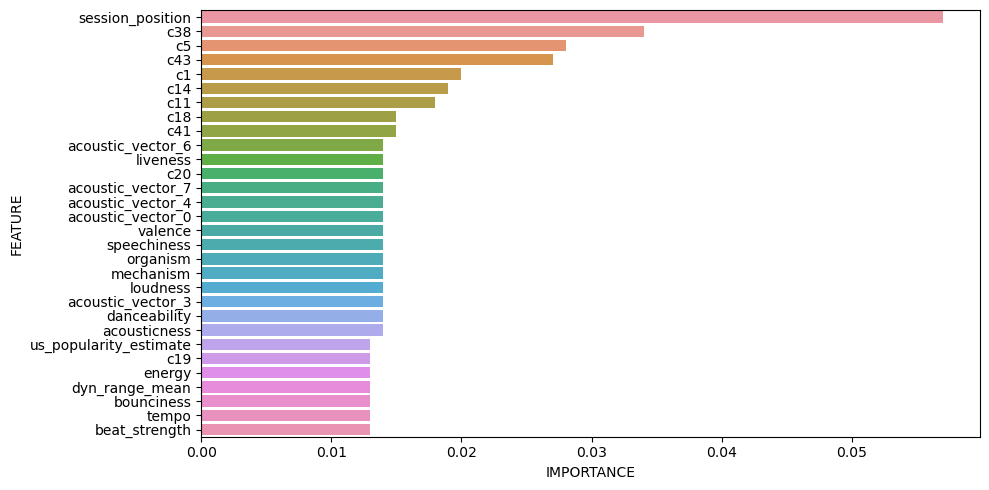

In [12]:
importances = pd.DataFrame({'FEATURE':X_train.columns,'IMPORTANCE':np.round(RF_MulClass.feature_importances_,3)})
importances = importances.sort_values('IMPORTANCE',ascending=False).set_index('FEATURE')

fig, ax = plt.subplots(figsize=(10,5)) 
sel_range = 30
sns.barplot(y = importances[0:sel_range].index, x = importances['IMPORTANCE'][0:sel_range], orient = 'h', ax = ax)

plt.tight_layout()
plt.show()

/Users/andrewchang/opt/anaconda3/envs/Springboard_DS_2022/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


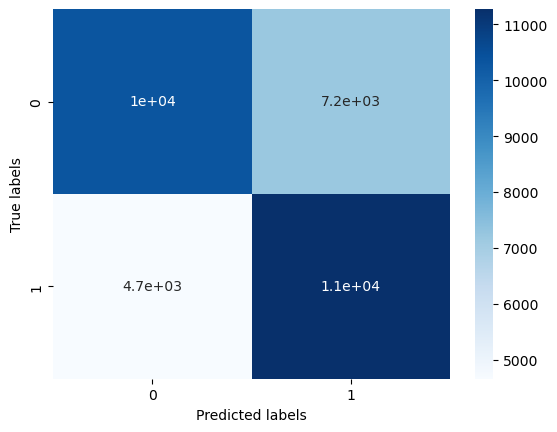

In [14]:
y_test_pred = RF_MulClass.predict(X_test2)
pl = confusion_matrix(y_test,y_test_pred)
ax= plt.subplot()
p=sns.heatmap(pl, annot=True,cmap ='Blues',ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

       False       0.69      0.59      0.64     17533
        True       0.61      0.71      0.66     15933

    accuracy                           0.65     33466
   macro avg       0.65      0.65      0.65     33466
weighted avg       0.65      0.65      0.64     33466



**Results of Model 3:** The model performs relatively well for no skip (0) and early skip (1), which is likely because they have more cases. But in general the model performance is not so good, compared to binary classification.

# Simple model 4: split the beginning/end of each sequence, random forest classifier with hyperparameter tuning, muticlasses
Not sure whether it can still be called as a simple model, but the hyperparameter tunning will be implemented here.

In [24]:
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, roc_auc_score

param_grid = {'n_estimators':np.arange(20,200,20), 
             'max_depth':[np.arange(10,100,10),None], 
             'class_weight': ['balanced', None]}
RF_MulClass_pt = RandomForestClassifier(random_state=23, n_jobs = -1)
rf_cv= GridSearchCV(RF_MulClass_pt,
                    param_grid,
                    cv=5, 
                    n_jobs = 6)
rf_cv.fit(X_train2,y_train)


pd.DataFrame(rf_cv.cv_results_).to_csv('../models/simpleModel/RF_GridSearchCV_noSkip_skip1_TF_processed.csv')
# from joblib import dump, load
# dump(rf_cv, '../models/simpleModel/RF_GridSearchCV_20221117.joblib') 

/Users/andrewchang/opt/anaconda3/envs/Springboard_DS_2022/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/andrewchang/opt/anaconda3/envs/Springboard_DS_2022/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/andrewchang/opt/anaconda3/envs/Springboard_DS_2022/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 68

In [25]:
pd.DataFrame(rf_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.290609,0.015745,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",20,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,36
1,2.072843,0.197340,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",40,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,22
2,1.915760,0.250434,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",60,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,21
3,1.994948,0.123349,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",80,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,23
4,2.137904,0.136769,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",100,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,32
5,1.972336,0.111442,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",120,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,29
6,2.034794,0.118573,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",140,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,19
7,2.106671,0.134895,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",160,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,34
8,2.092600,0.124978,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",180,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,33
9,65.569889,1.589027,0.348950,0.094062,balanced,None,20,"{'class_weight': 'balanced', 'max_depth': None...",0.614998,0.606889,0.614217,0.609493,0.615133,0.612146,0.003347,18


In [26]:
print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))

Best Score:0.6366821772019311
Best Parameters: {'class_weight': None, 'max_depth': None, 'n_estimators': 180}


In [27]:
pd.DataFrame(rf_cv.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_class_weight', 'param_max_depth', 'param_n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [95]:
pd.DataFrame(rf_cv.cv_results_).sort_values('mean_test_f1_weighted')[['params','mean_test_f1_weighted','mean_test_accuracy','mean_test_balanced_accuracy']].head()

,params,mean_test_f1_weighted,mean_test_accuracy,mean_test_balanced_accuracy
45,"{'class_weight': 'balanced', 'max_depth': 60, ...",0.566791,0.598457,0.362806
72,"{'class_weight': 'balanced', 'max_depth': 90, ...",0.566860,0.598569,0.362893
63,"{'class_weight': 'balanced', 'max_depth': 80, ...",0.566860,0.598569,0.362893
54,"{'class_weight': 'balanced', 'max_depth': 70, ...",0.566860,0.598569,0.362893
36,"{'class_weight': 'balanced', 'max_depth': 50, ...",0.567050,0.598874,0.363244


**Results of Model 4:** Without feature engineering, the best parameters of the random forest model are {'class_weight': None, 'max_depth': 10, 'n_estimators': 50}, and the best accuracy was 64.4%, which is only 2% better.

# Split each sequence: multi-class (SVM)

In [31]:
# clf = make_pipeline(StandardScaler(), SVC(verbose = True, random_state=23))
# clf.fit(X_train, y_train)

[LibSVM]..............................................................................................................................*..............................................................................................................................*.*
optimization finished, #iter = 252227
obj = -36073.929342, rho = 0.292277
nSV = 47263, nBSV = 30604
.................................................*................................*
optimization finished, #iter = 81440
obj = -23087.018105, rho = -0.397195
nSV = 28683, nBSV = 21009
.................................................................*...........................................*.*
optimization finished, #iter = 108221
obj = -29105.703096, rho = -0.295036
nSV = 35559, nBSV = 26185
......................................................................................*.........................................................................................*.*
optimization finished, #iter = 176460
obj = -22031.591988

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=23, verbose=True))])

In [32]:
# score_clf_train = clf.score(X_train,y_train)
# score_clf_test = clf.score(X_test,y_test)
# print('score_train',score_clf_train)
# print('score_test',score_clf_test)

score_train 0.6678768580653801
score_test 0.6515568039203968


In [33]:
# from joblib import dump, load
# dump(clf, '../models/simpleModel/SVC_simple.joblib') 

['../models/simpleModel/SVC_simple.joblib']